In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve, auc,
    precision_recall_curve, average_precision_score
)
from transformers import AutoTokenizer, AutoModel
import torch

In [ ]:
class HateSpeechXGBClassifier:
    def __init__(
        self,
        threshold: float = 0.75,
        n_estimators: int = 100,
        max_depth: int = 6,
        learning_rate: float = 0.3,
        bert_model_name: str = "Hate-speech-CNERG/bert-base-uncased-hatexplain",
        max_length: int = 128,
        batch_size: int = 32
    ):
        self.threshold = threshold
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
        self.encoder = AutoModel.from_pretrained(bert_model_name).to(self.device)
        self.max_length = max_length
        self.batch_size = batch_size
        self.model = XGBClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            random_state=42,
            eval_metric="logloss"
        )

    def embed(self, texts: pd.Series) -> np.ndarray:
        """
        Generate BERT embeddings for a series of texts using the [CLS] token representation or pooled output.
        """
        self.encoder.eval()
        all_embeddings = []
        for start in range(0, len(texts), self.batch_size):
            batch_texts = texts.iloc[start : start + self.batch_size].tolist()
            encoded = self.tokenizer(
                batch_texts,
                padding=True,
                truncation=True,
                max_length=self.max_length,
                return_tensors="pt"
            )
            encoded = {k: v.to(self.device) for k, v in encoded.items()}
            with torch.no_grad():
                outputs = self.encoder(**encoded)
            if hasattr(outputs, "pooler_output"):
                embeddings = outputs.pooler_output
            else:
                embeddings = outputs.last_hidden_state[:, 0, :]
            embeddings = embeddings.cpu().numpy()
            all_embeddings.append(embeddings)
        return np.vstack(all_embeddings)

    def train(self, X: pd.Series, y: pd.Series) -> None:
        X_embed = self.embed(X)
        self.model.fit(X_embed, y)

    def predict_proba(self, X: pd.Series) -> pd.Series:
        X_embed = self.embed(X)
        proba = self.model.predict_proba(X_embed)[:, 1]
        return pd.Series(proba, index=X.index)

    def predict(self, X: pd.Series) -> pd.Series:
        proba = self.predict_proba(X)
        return (proba > self.threshold).astype(int)

    def evaluate(self, X_test: pd.Series, y_test: pd.Series) -> None:
        y_pred = self.predict(X_test)
        print(classification_report(y_test, y_pred))

    def plot_confusion_matrix(self, y_true, y_pred):
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=["Not Hate", "Hate"],
            yticklabels=["Not Hate", "Hate"]
        )
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

    def show_misclassifications(self, X: pd.Series, y_true: pd.Series, y_pred: pd.Series):
        mismatches = X[(y_true != y_pred)]
        print("\nFALSE POSITIVES:")
        print(mismatches[(y_true == 0) & (y_pred == 1)].head(5).to_string(index=False))

        print("\nFALSE NEGATIVES:")
        print(mismatches[(y_true == 1) & (y_pred == 0)].head(5).to_string(index=False))

In [ ]:
def main():
    train_df = pd.read_csv("../data/train_data.csv")
    test_df = pd.read_csv("../data/test_data_clean.csv")

    model = HateSpeechXGBClassifier(
        threshold=0.25,
        n_estimators=100,
        max_depth=6,
        learning_rate=0.3
    )

    # Prepare training and testing sets
    X_train = train_df["text"]
    y_train = train_df["label"].astype(int)
    X_test = test_df["comment"]
    y_test = test_df["isHate"].astype(int)

    # Train and evaluate
    model.train(X_train, y_train)
    model.evaluate(X_test, y_test)

    # Generate predictions and probabilities
    test_probs = model.predict_proba(X_test)
    test_preds = model.predict(X_test)

    # Confusion matrix
    plt.figure(figsize=(10, 5))
    model.plot_confusion_matrix(y_test, test_preds)

    # ROC Curve
    plt.figure(figsize=(8, 6))
    fpr_test, tpr_test, _ = roc_curve(y_test, test_probs)
    roc_auc_test = auc(fpr_test, tpr_test)
    plt.plot(fpr_test, tpr_test, label=f"ROC curve (AUC = {roc_auc_test:.2f})", linewidth=2)
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - Test Data")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, test_probs)
    avg_prec = average_precision_score(y_test, test_probs)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f"PR curve (AP = {avg_prec:.2f})", linewidth=2)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve - Test Data")
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.show()

tokenizer_config.json:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

              precision    recall  f1-score   support

           0       0.95      0.23      0.37       835
           1       0.19      0.94      0.32       163

    accuracy                           0.34       998
   macro avg       0.57      0.58      0.34       998
weighted avg       0.83      0.34      0.36       998



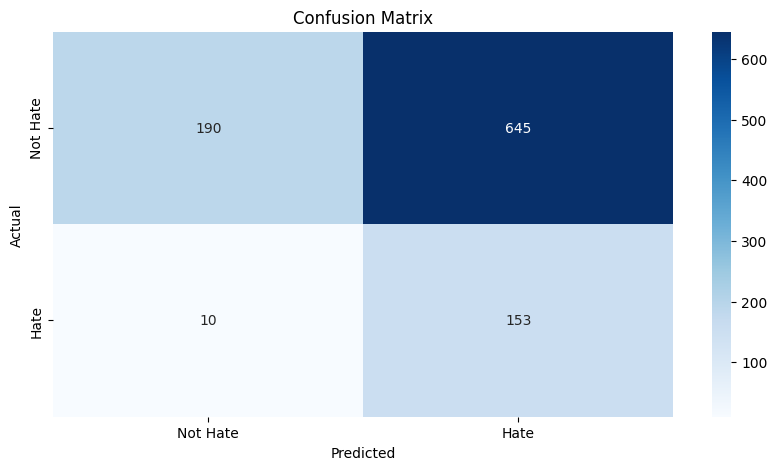

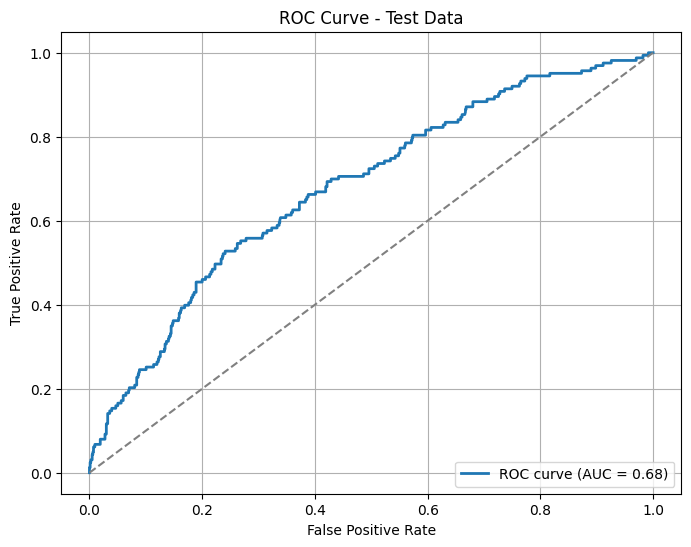

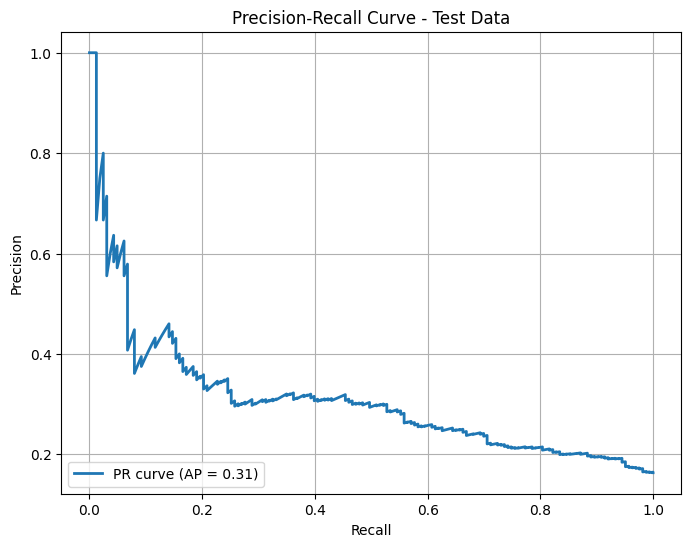

In [4]:
main()